In [1]:
import numpy as np
import numpy.random as rn
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from math import log, factorial
from scipy.optimize import minimize

In [ ]:
## q1

In [3]:
train_data = pd.read_csv(
    '/Users/giovannimaya/Downloads/data/PCC_study_train.csv')
train_data = train_data.drop(columns='Unnamed: 0')
vaccinated_train_data = train_data[train_data['vax_status'] == 'Vaccinated']
unvaccinated_train_data = train_data[train_data['vax_status']
                                     == 'Unvaccinated']

vax_cond_probs = vaccinated_train_data.groupby(
    ['WBscore', 'PCCsymp']).size() / len(vaccinated_train_data)
unvax_cond_probs = unvaccinated_train_data.groupby(
    ['WBscore', 'PCCsymp']).size() / len(unvaccinated_train_data)

vax_cond_probs_table = vax_cond_probs.unstack().fillna(0)
unvax_cond_probs_table = unvax_cond_probs.unstack().fillna(0)

print("Conditional Probabilities for Vaccinated Patients:")
print(vax_cond_probs_table)
print("\nConditional Probabilities for Unvaccinated Patients:")
print(unvax_cond_probs_table)

train_data_pivot = pd.pivot_table(train_data,
                                  index=['WBscore', 'PCCsymp'],
                                  columns='vax_status',
                                  aggfunc='size',
                                  fill_value=0)


total_num_yes = (train_data['vax_status'] == 'Vaccinated').sum()
total_num_no = (train_data['vax_status'] == 'Unvaccinated').sum()

class_prob_yes = total_num_yes / (total_num_yes + total_num_no)
class_prob_no = 1 - class_prob_yes
class_prob_yes, class_prob_no

Conditional Probabilities for Vaccinated Patients:
PCCsymp        Less      More      Same
WBscore                                
Improved   0.750000  0.000000  0.027778
Unchanged  0.083333  0.027778  0.027778
Worsened   0.027778  0.027778  0.027778

Conditional Probabilities for Unvaccinated Patients:
PCCsymp        Less      More      Same
WBscore                                
Improved   0.076923  0.025641  0.076923
Unchanged  0.128205  0.102564  0.282051
Worsened   0.000000  0.153846  0.153846


In [5]:
def calculate_likelihood(outcomes, cond_probs_table, class_prob):
    likelihood = class_prob
    for outcome in outcomes:
        wb_score = outcome['WBscore']
        pcc_symp = outcome['PCCsymp']
        if wb_score in cond_probs_table.index and pcc_symp in cond_probs_table.columns:
            likelihood *= cond_probs_table.loc[wb_score, pcc_symp]
        else:
            likelihood *= 0
        return likelihood

In [6]:
example_input = [{'WBscore': 'Improved', 'PCCsymp': 'Same'}]
prob_vaccinated = len(vaccinated_train_data) / len(train_data)
prob_unvaccinated = len(unvaccinated_train_data) / len(train_data)

likelihood_vaccinated = calculate_likelihood(
    example_input, vax_cond_probs_table, prob_vaccinated)
likelihood_unvaccinated = calculate_likelihood(
    example_input, unvax_cond_probs_table, prob_unvaccinated)

print(f"Likelihood vaccinated: {likelihood_vaccinated}")
print(f"Likelihood unvaccinated: {likelihood_unvaccinated}")

Likelihood vaccinated: 0.013333333333333332
Likelihood unvaccinated: 0.04


In [ ]:
WBscore_mapping = {'Improved': 0, 'Unchanged': 1, 'Worsened': 2}
PCCsymp_mapping = {'Less': 0, 'Same': 1, 'More': 2}
vax_status_mapping = {'Vaccinated': 0, 'Unvaccinated': 1}

train_data['WBscore_encoded'] = train_data['WBscore'].map(WBscore_mapping)
train_data['PCCsymp_encoded'] = train_data['PCCsymp'].map(PCCsymp_mapping)
train_data['vax_status_encoded'] = train_data['vax_status'].map(
    vax_status_mapping)


def calculate_conditional_probabilities(data, feature, target):
    probabilities = {}
    for target_value in data[target].unique():
        target_data = data[data[target] == target_value]
        counts = target_data[feature].value_counts()
        total = counts.sum()
        probabilities[target_value] = (counts / total).to_dict()
    return probabilities


cond_probs_wbscore = calculate_conditional_probabilities(
    train_data, 'WBscore_encoded', 'vax_status_encoded')
cond_probs_pccsymp = calculate_conditional_probabilities(
    train_data, 'PCCsymp_encoded', 'vax_status_encoded')

prob_vax = (train_data['vax_status_encoded'] ==
            vax_status_mapping['Vaccinated']).mean()
prob_unvax = 1 - prob_vax

wbscore_encoded = WBscore_mapping[row['WBscore']]
pccsymp_encoded = PCCsymp_mapping[row['PCCsymp']]
likelihood_vax = (cond_probs_wbscore[vax_status_mapping['Vaccinated']].get(wbscore_encoded, 0) *
                      cond_probs_pccsymp[vax_status_mapping['Vaccinated']].get(pccsymp_encoded, 0) * prob_vax)
likelihood_unvax = (cond_probs_wbscore[vax_status_mapping['Unvaccinated']].get(wbscore_encoded, 0) *
                        cond_probs_pccsymp[vax_status_mapping['Unvaccinated']].get(pccsymp_encoded, 0) * prob_unvax)

In [96]:
train_data = pd.read_csv(
    '/Users/giovannimaya/Downloads/data/PCC_study_train.csv')
test_data = pd.read_csv(
    '/Users/giovannimaya/Downloads/data/PCC_study_test.csv')

WBscore_mapping = {'Improved': 0, 'Unchanged': 1, 'Worsened': 2}
PCCsymp_mapping = {'Less': 0, 'Same': 1, 'More': 2}
vax_status_mapping = {'Vaccinated': 0, 'Unvaccinated': 1}

train_data['WBscore_encoded'] = train_data['WBscore'].map(WBscore_mapping)
train_data['PCCsymp_encoded'] = train_data['PCCsymp'].map(PCCsymp_mapping)
train_data['vax_status_encoded'] = train_data['vax_status'].map(
    vax_status_mapping)


def calculate_conditional_probabilities(data, feature, target):
    probabilities = {}
    for target_value in data[target].unique():
        target_data = data[data[target] == target_value]
        counts = target_data[feature].value_counts()
        total = counts.sum()
        probabilities[target_value] = (counts / total).to_dict()
    return probabilities


cond_probs_wbscore = calculate_conditional_probabilities(
    train_data, 'WBscore_encoded', 'vax_status_encoded')
cond_probs_pccsymp = calculate_conditional_probabilities(
    train_data, 'PCCsymp_encoded', 'vax_status_encoded')

prob_vax = (train_data['vax_status_encoded'] ==
            vax_status_mapping['Vaccinated']).mean()
prob_unvax = 1 - prob_vax


def predict(row, prob_vax, prob_unvax):
    wbscore_encoded = WBscore_mapping[row['WBscore']]
    pccsymp_encoded = PCCsymp_mapping[row['PCCsymp']]

    likelihood_vax = (cond_probs_wbscore[vax_status_mapping['Vaccinated']].get(wbscore_encoded, 0) *
                      cond_probs_pccsymp[vax_status_mapping['Vaccinated']].get(pccsymp_encoded, 0) * prob_vax)
    likelihood_unvax = (cond_probs_wbscore[vax_status_mapping['Unvaccinated']].get(wbscore_encoded, 0) *
                        cond_probs_pccsymp[vax_status_mapping['Unvaccinated']].get(pccsymp_encoded, 0) * prob_unvax)

    predicted_class = vax_status_mapping['Vaccinated'] if likelihood_vax > likelihood_unvax else vax_status_mapping['Unvaccinated']
    return predicted_class

test_data['Prediction'] = test_data.apply(predict, args=(prob_vax, prob_unvax), axis=1).map({
    v: k for k, v in vax_status_mapping.items()})

print(test_data[['WBscore', 'PCCsymp', 'Prediction']].head())

0.48
     WBscore PCCsymp  Prediction
0   Improved    Less  Vaccinated
1   Improved    Less  Vaccinated
2   Improved    Less  Vaccinated
3   Worsened    Less  Vaccinated
4  Unchanged    Less  Vaccinated


In [98]:
def calc_likelihood(outcome, prob_vax, prob_unvax):
    wbscore_encoded = WBscore_mapping[outcome['WBscore']]
    pccsymp_encoded = PCCsymp_mapping[outcome['PCCsymp']]

    likelihood_vax = (cond_probs_wbscore[vax_status_mapping['Vaccinated']].get(wbscore_encoded, 0) *
                      cond_probs_pccsymp[vax_status_mapping['Vaccinated']].get(pccsymp_encoded, 0) * prob_vax)
    likelihood_unvax = (cond_probs_wbscore[vax_status_mapping['Unvaccinated']].get(wbscore_encoded, 0) *
                        cond_probs_pccsymp[vax_status_mapping['Unvaccinated']].get(pccsymp_encoded, 0) * prob_unvax)

    return likelihood_vax, likelihood_unvax


example_input = {'WBscore': 'Improved', 'PCCsymp': 'Same'}
print(calc_likelihood(example_input, prob_vax, prob_unvax))

(0.031111111111111107, 0.04786324786324786)


In [86]:
# sklearn  of bayes 
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import CategoricalNB

train_data_2 = pd.read_csv(
    '/Users/giovannimaya/Downloads/data/PCC_study_train.csv')
test_data_2 = pd.read_csv(
    '/Users/giovannimaya/Downloads/data/PCC_study_test.csv')

le_WBscore = LabelEncoder()
le_PCCsymp = LabelEncoder()
le_vax_status = LabelEncoder()

train_data_2['WBscore_encoded'] = le_WBscore.fit_transform(train_data_2['WBscore'])
train_data_2['PCCsymp_encoded'] = le_PCCsymp.fit_transform(train_data_2['PCCsymp'])
train_data_2['vax_status_encoded'] = le_vax_status.fit_transform(
    train_data_2['vax_status'])

test_data_2['WBscore_encoded'] = le_WBscore.transform(test_data_2['WBscore'])
test_data_2['PCCsymp_encoded'] = le_PCCsymp.transform(test_data_2['PCCsymp'])

X_train = train_data_2[['WBscore_encoded', 'PCCsymp_encoded']]
y_train = train_data_2['vax_status_encoded']

cnb_classifier = CategoricalNB()
cnb_classifier.fit(X_train, y_train)

X_test = test_data_2[['WBscore_encoded', 'PCCsymp_encoded']]

cnb_predictions_encoded = cnb_classifier.predict(X_test)

test_data_2['cnb_predicted_vax_status'] = le_vax_status.inverse_transform(
    cnb_predictions_encoded)

print(test_data_2[['WBscore', 'PCCsymp', 'cnb_predicted_vax_status']].head())

     WBscore PCCsymp cnb_predicted_vax_status
0   Improved    Less               Vaccinated
1   Improved    Less               Vaccinated
2   Improved    Less               Vaccinated
3   Worsened    Less               Vaccinated
4  Unchanged    Less               Vaccinated


In [11]:
# end of q1

In [183]:
from sklearn.model_selection import train_test_split
iris_df = pd.read_csv("/Users/giovannimaya/Downloads/data/iris.csv")
iris_df = iris_df.drop(columns=['rownames'])
iris_df.head()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [184]:
X_train, X_test, y_train, y_test = train_test_split(
    iris_df.drop('Species', axis=1), iris_df['Species'], test_size=0.3, random_state=42, stratify=iris_df['Species'])
train_data = X_train.copy()
train_data['Species'] = y_train
train_data

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
98,5.1,2.5,3.0,1.1,versicolor
68,6.2,2.2,4.5,1.5,versicolor
19,5.1,3.8,1.5,0.3,setosa
143,6.8,3.2,5.9,2.3,virginica
99,5.7,2.8,4.1,1.3,versicolor
...,...,...,...,...,...
37,4.9,3.6,1.4,0.1,setosa
79,5.7,2.6,3.5,1.0,versicolor
33,5.5,4.2,1.4,0.2,setosa
94,5.6,2.7,4.2,1.3,versicolor


/Users/giovannimaya/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/giovannimaya/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/giovannimaya/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


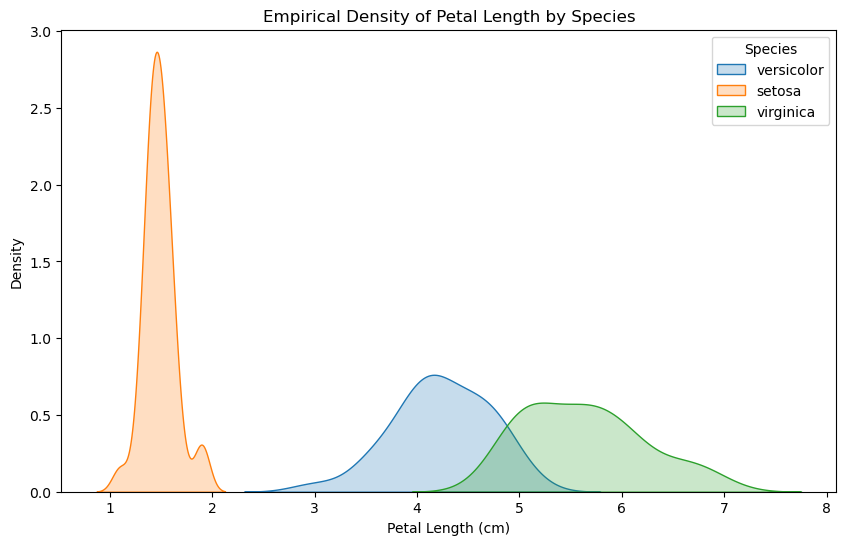

In [185]:
plt.figure(figsize=(10, 6))

for species in train_data['Species'].unique():
    subset = train_data[train_data['Species'] == species]
    sns.kdeplot(subset['Petal.Length'], label=species, fill=True)

plt.title('Empirical Density of Petal Length by Species')
plt.xlabel('Petal Length (cm)')
plt.ylabel('Density')
plt.legend(title='Species')
plt.show()

In [187]:
petal_length_stats = train_data.groupby('Species')['Petal.Length'].agg([
    'mean', 'std']).reset_index()

print(petal_length_stats)

      Species      mean       std
0      setosa  1.485714  0.153667
1  versicolor  4.237143  0.466581
2   virginica  5.631429  0.576384


In [188]:
from scipy.stats import norm

petal_length_to_classify = 4.31

likelihoods = {
    species: norm.pdf(petal_length_to_classify,
                      loc=row['mean'], scale=row['std'])
   for species, row in petal_length_stats.set_index('Species').iterrows()
}

likelihoods

{'setosa': 1.1542161536898683e-73,
 'versicolor': 0.8446730137297308,
 'virginica': 0.04998625890120865}

/Users/giovannimaya/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/giovannimaya/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/giovannimaya/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/giovannimaya/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed

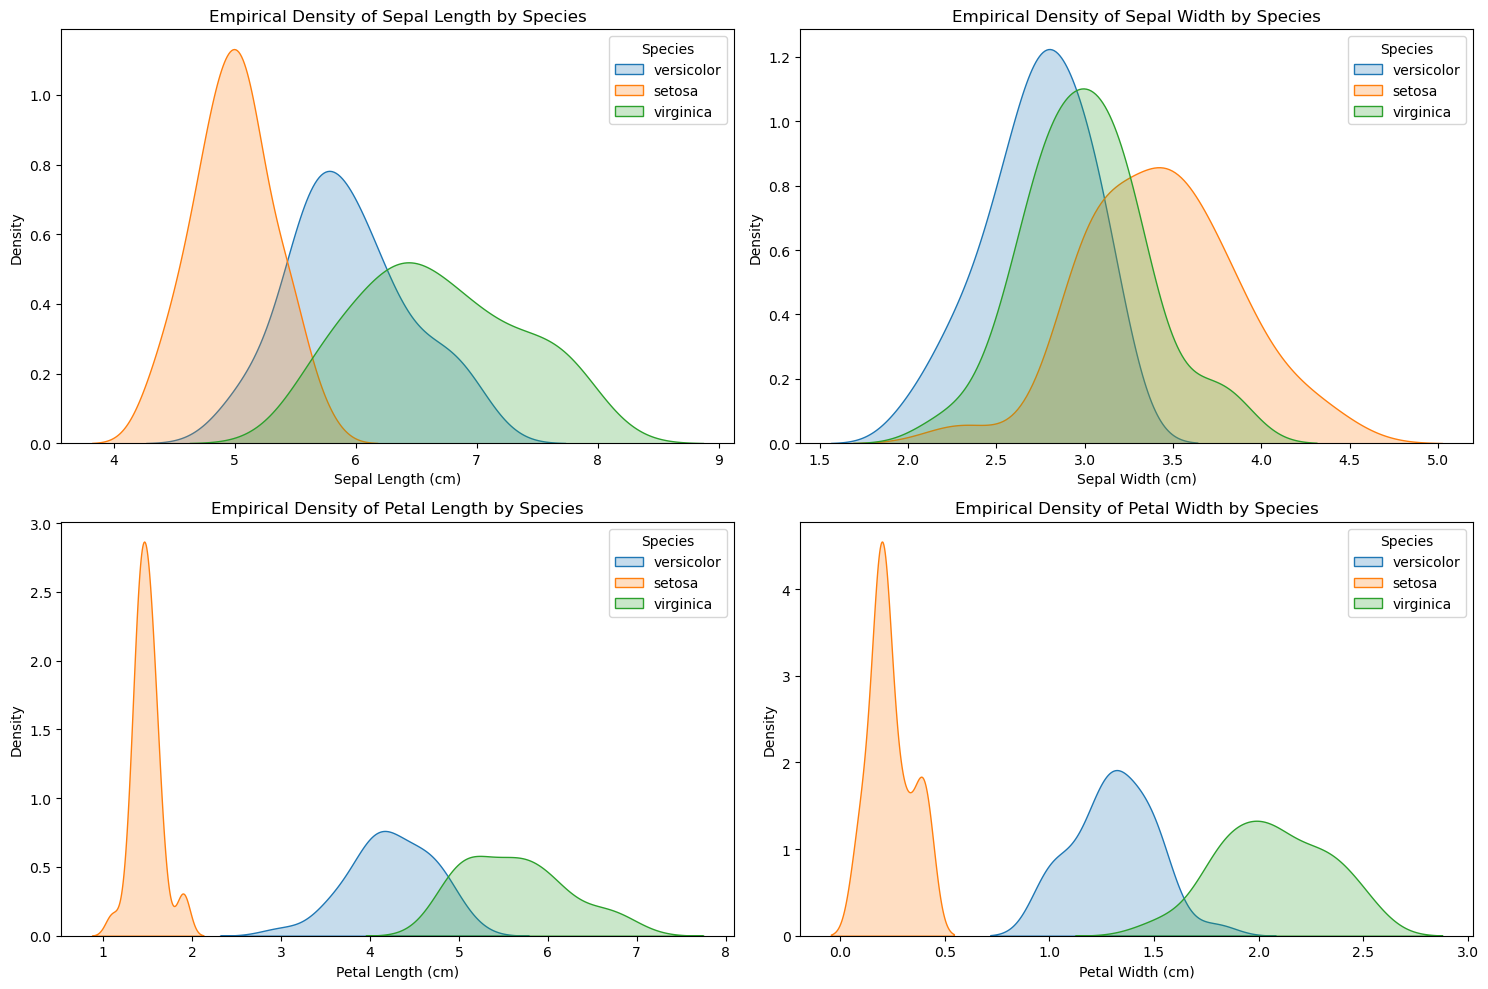

In [127]:
variables = ['Sepal.Length', 'Sepal.Width', 'Petal.Length', 'Petal.Width']
titles = ['Sepal Length', 'Sepal Width', 'Petal Length', 'Petal Width']

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

for ax, var, title in zip(axs.flatten(), variables, titles):
    for species in train_data['Species'].unique():
        subset = train_data[train_data['Species'] == species]
        sns.kdeplot(subset[var], ax=ax, label=species, fill=True)
    ax.set_title(f'Empirical Density of {title} by Species')
    ax.set_xlabel(f'{title} (cm)')
    ax.set_ylabel('Density')
    ax.legend(title='Species')

plt.tight_layout()
plt.show()

In [128]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
import pandas as pd

X = iris_df.drop('Species', axis=1)
y = iris_df['Species']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

gnb = GaussianNB()
gnb.fit(X_train, y_train)

iris_to_classify = [[6.56, 3.18, 4.31, 1.32]]
predicted_species = gnb.predict(iris_to_classify)
print("Predicted species for the given iris measurements:",
      predicted_species[0])

y_pred = gnb.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred, labels=gnb.classes_)
conf_matrix_df = pd.DataFrame(
    conf_matrix, index=gnb.classes_, columns=gnb.classes_)

print("Confusion Matrix for the Test Set:")
print(conf_matrix_df)

Predicted species for the given iris measurements: versicolor
Confusion Matrix for the Test Set:
            setosa  versicolor  virginica
setosa          15           0          0
versicolor       0          14          1
virginica        0           3         12


/Users/giovannimaya/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


In [189]:
predictions_df = pd.DataFrame(
    {'Predicted Species': y_pred}, index=X_test.index)
print(predictions_df.head())

    Predicted Species
107         virginica
63         versicolor
133        versicolor
56         versicolor
127         virginica


In [130]:
from sklearn.metrics import accuracy_score

# Assuming y_test contains the true species labels and y_pred contains the predicted species labels from the test set
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy of the Gaussian Naive Bayes classifier:", accuracy)

Accuracy of the Gaussian Naive Bayes classifier: 0.9111111111111111


In [76]:
## end of q2 and q3
ham_spam_df = pd.read_csv(
    '/Users/giovannimaya/Downloads/spam.csv', encoding="latin-1")
ham_spam_df = ham_spam_df[['v1', 'v2']].rename(
    columns={'v1': 'Class', 'v2': 'Text'})
ham_spam_df

,Class,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [148]:
import nltk
from itertools import islice
ham_spam_df = pd.read_csv(
    '/Users/giovannimaya/Downloads/spam.csv', encoding="latin-1")
ham_spam_df = ham_spam_df[['v1', 'v2']].rename(
    columns={'v1': 'Class', 'v2': 'Text'})

ham_spam_df['Text'] = ham_spam_df['Text'].apply(
    lambda x: x.replace('.', ' ').replace(',', ' '))
ham_spam_df['Text'] = ham_spam_df['Text'].apply(
    lambda x: x.replace(':', ' ').replace(';', ' '))
ham_spam_df['Text'] = ham_spam_df['Text'].apply(
    lambda x: x.replace('?', ' ').replace('!', ' '))  # are these pertinent?
ham_spam_df['Text'] = ham_spam_df['Text'].apply(
    lambda x: x.replace('(', ' ').replace(')', ' '))
ham_spam_df['Text'] = ham_spam_df['Text'].apply(
    lambda x: x.replace('"', ' ').replace('/', ' '))
ham_spam_df['Text'] = ham_spam_df['Text'].apply(lambda x: x.lower())


def tokenize_ham_spam(df, clss):
    '''
    Input: a dataframe with the spam.csv data (cleaned up) and 
           the required class ('ham' or 'spam'). 
    Output: a ham or spam dataframes, a ham or spam token list, and 
            a ham or spam frequency distribution object
    '''
    clss_df = df[df.Class == clss]
    # token object, behaves like a dictionary
    clss_tok = nltk.word_tokenize(clss_df.Text.sum())
    clss_freq_dist_obj = nltk.probability.FreqDist(
        clss_tok)  # frequency distribution object
    return (clss_df, clss_tok, clss_freq_dist_obj)


ham_df,  ham_tok,  ham_freqs = tokenize_ham_spam(ham_spam_df, 'ham')
spam_df, spam_tok, spam_freqs = tokenize_ham_spam(ham_spam_df, 'spam')

# See https://www.nltk.org/api/nltk.probability.FreqDist.html for more functions
print(list(islice(ham_freqs.items(), 10)))
print(len(ham_freqs.keys()))
print("The total number of words in ham is %d." % ham_freqs.N())
print("The total number of words in spam is %d." % spam_freqs.N())
print("'Sorry' apppears a fraction %.2e of all words." %
      (ham_freqs.freq('sorry')))
print("'Sorry' appears %d times." %
      (ham_freqs.N() * ham_freqs.freq('sorry')))
print("'Sorry' apppears a fraction %.2e of all words." %
      (spam_freqs.freq('sorry')))
print("'Sorry' appears %d times." %
      (spam_freqs.N() * ham_freqs.freq('sorry')))

[('go', 246), ('until', 21), ('jurong', 1), ('point', 11), ('crazy', 9), ('available', 15), ('only', 130), ('in', 808), ('bugis', 7), ('n', 139)]
8461
The total number of words in ham is 70635.
The total number of words in spam is 18678.
'Sorry' apppears a fraction 1.64e-03 of all words.
'Sorry' appears 116 times.
'Sorry' apppears a fraction 5.35e-05 of all words.
'Sorry' appears 30 times.


In [190]:
import string
spam_only = ham_spam_df[ham_spam_df['Class'] == 'spam']
ham_only = ham_spam_df[ham_spam_df['Class'] == 'ham']
print(len(spam_only), len(ham_only))
spam_messages = spam_only['Class'].str.cat(sep=' ')
ham_messages = ham_only['Class'].str.cat(sep=' ')

def simple_tokenize(text):
    return text.replace(',', '').replace('?', '').lower().split()

def calculate_message_probability(message, freq_dist):
    message_tokens = simple_tokenize(message)
    probability = 1
    for token in message_tokens:
        word_probability = freq_dist.freq(token)
        probability *= word_probability
    return probability


example_message = "Sorry my roommates took forever, it ok if I come by now?"
ham_probability = calculate_message_probability(
    example_message, ham_freqs)
spam_probability = calculate_message_probability(
    example_message, spam_freqs)

ham_probability, spam_probability

747 4825


(2.2066341522197914e-33, 0.0)

In [191]:
import math

def log_odds(message, freq_dist):
    message_tokens = simple_tokenize(message)
    log_probability = 0
    for token in message_tokens:
        word_probability = (freq_dist.freq(token))
        log_probability += math.log(word_probability)
    return log_probability


ham_log_probability = log_odds(
    example_message, ham_freqs)
spam_log_probability = log_odds(
    example_message, spam_freqs)

ham_log_probability, spam_log_probability

ValueError: math domain error

In [71]:
def score_message(message, ham_freq_dist, spam_freq_dist):
    log_odds_ham = log_odds(
        message, ham_freq_dist)
    log_odds_spam = log_odds(
        message, spam_freq_dist)

    return log_odds_ham - log_odds_spam


message_score = score_message(example_message, ham_freqs,
                              spam_freqs)

message_score

0.5108535299381884

In [131]:
# redo of question 4 & 5

In [152]:
from itertools import islice
import nltk
import pandas as pd

file_path = '/Users/giovannimaya/Downloads/data/spam.csv'
spam_ham_data = pd.read_csv(file_path, encoding="latin-1")
# nltk.download("punkt") # had to download this resource
# first time around

###########################
#   Rudimentary Clean up  #
# (much more can be done) #
###########################
ham_spam_df = pd.read_csv('data/spam.csv', encoding='ISO-8859-1')
ham_spam_df = ham_spam_df[['v1', 'v2']].rename(
    columns={'v1': 'Class', 'v2': 'Text'})

ham_spam_df['Text'] = ham_spam_df['Text'].apply(
    lambda x: x.replace('.', ' ').replace(',', ' '))
ham_spam_df['Text'] = ham_spam_df['Text'].apply(
    lambda x: x.replace(':', ' ').replace(';', ' '))
ham_spam_df['Text'] = ham_spam_df['Text'].apply(
    lambda x: x.replace('?', ' ').replace('!', ' '))  # are these pertinent?
ham_spam_df['Text'] = ham_spam_df['Text'].apply(
    lambda x: x.replace('(', ' ').replace(')', ' '))
ham_spam_df['Text'] = ham_spam_df['Text'].apply(
    lambda x: x.replace('"', ' ').replace('/', ' '))
ham_spam_df['Text'] = ham_spam_df['Text'].apply(lambda x: x.lower())


def tokenize_ham_spam(df, clss):
    '''
    Input: a dataframe with the spam.csv data (cleaned up) and 
           the required class ('ham' or 'spam'). 
    Output: a ham or spam dataframes, a ham or spam token list, and 
            a ham or spam frequency distribution object
    '''
    clss_df = df[df.Class == clss]
    # token object, behaves like a dictionary
    clss_tok = nltk.word_tokenize(clss_df.Text.sum())
    clss_freq_dist_obj = nltk.probability.FreqDist(
        clss_tok)  # frequency distribution object
    return (clss_df, clss_tok, clss_freq_dist_obj)


ham_df,  ham_tok,  ham_freqs = tokenize_ham_spam(ham_spam_df, 'ham')
spam_df, spam_tok, spam_freqs = tokenize_ham_spam(ham_spam_df, 'spam')

,Class,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [153]:
labels_column = spam_ham_data.columns[0]
text_column = spam_ham_data.columns[1]

# Splitting the spam_ham_dataset
spam_df = spam_ham_data[spam_ham_data[labels_column] == "spam"]
ham_df = spam_ham_data[spam_ham_data[labels_column] == "ham"]

# Number of messages in each spam_ham_data frame
num_spam = spam_df.shape[0]
num_ham = ham_df.shape[0]

num_spam, num_ham

(747, 4825)

In [169]:
import string
long_string_spam = spam_df[text_column].str.cat(sep=' ')
long_string_ham = ham_df[text_column].str.cat(sep=' ')

tokens_spam = long_string_spam.split()
tokens_ham = long_string_ham.split()

def remove_punctuation(tokens):
    table = str.maketrans('', '', string.punctuation)
    return [word.translate(table) for word in tokens]

tokens_spam = remove_punctuation(tokens_spam)
tokens_ham = remove_punctuation(tokens_ham)

tokens_spam[:10], tokens_ham[:10]


(['Free', 'entry', 'in', '2', 'a', 'wkly', 'comp', 'to', 'win', 'FA'],
 ['Go',
  'until',
  'jurong',
  'point',
  'crazy',
  'Available',
  'only',
  'in',
  'bugis',
  'n'])

In [175]:
from nltk import FreqDist

# Counting the frequency of each word in both spam and ham tokens
freq_dist_spam = FreqDist(tokens_ham)
freq_dist_ham = FreqDist(tokens_spam)

# Number of unique tokens in each dictionary
num_tokens_spam = len(freq_dist_spam)
num_tokens_ham = len(freq_dist_ham)

# Calculating the probability of the word "Sorry" occurring in each dictionary
prob_sorry_spam = freq_dist_spam['Sorry'] / sum(freq_dist_spam.values())
prob_sorry_ham = freq_dist_ham['Sorry'] / sum(freq_dist_ham.values())

num_tokens_spam, num_tokens_ham, prob_sorry_spam, prob_sorry_ham

(9129, 3641, 0.0015908228494702123, 0.00016837851490149856)

In [192]:
# --- START OF Q4 ----

# q1
spam_data = pd.read_csv(
    '/Users/giovannimaya/Downloads/spam.csv', encoding="latin-1")
spam_data = spam_data.rename(columns={'v1': 'Category', 'v2': 'Message'})
spam_data = spam_data.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'])
spam_data

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [193]:
# q2

ham = spam_data[spam_data['Category'] == 'ham']
spam = spam_data[spam_data['Category'] == 'spam']
ham

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
6,ham,Even my brother is not like to speak with me. ...
...,...,...
5565,ham,Huh y lei...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [195]:
ham_text = ham['Message'].str.cat(sep=' ').split()
spam_text = spam['Message'].str.cat(sep=' ').split()

In [197]:
from nltk.probability import FreqDist

freq_ham = FreqDist(ham_text)
freq_spam = FreqDist(spam_text)
spam_token_count = len(freq_spam)
ham_token_count = len(freq_ham)
sorry_spam_prob = freq_spam['Sorry'] / \
    sum(freq_spam.values()) 
sorry_ham_prob = freq_ham['Sorry'] / \
    sum(freq_ham.values()) 
spam_token_count, ham_token_count, sorry_spam_prob, sorry_ham_prob

(4312, 12479, 5.6126171633832856e-05, 0.0007443299570915672)

In [216]:
def calculate_message_probability(message, freq_dist):
    message_tokens = message.split()
    message_probability = 1
    total_token_count = sum(freq_dist.values())

    for token in message_tokens:
        token_probability = (
            freq_dist[token]) / (total_token_count)
        message_probability *= token_probability

    return message_probability


example_message = "Sorry my roommates took forever, it ok if I come by now?"


def calculate_log_odds(message, freq_dist, total_token_count, vocab_size, alpha=1):
    message_tokens = message.split()
    log_odds = 0

    for token in message_tokens:
        token_probability = (
            freq_dist[token] + alpha) / (total_token_count + alpha * vocab_size)
        log_odds += log(token_probability)

    return log_odds
prob_message_ham = calculate_message_probability(
    example_message, freq_ham)
prob_message_spam = calculate_message_probability(
    example_message, freq_spam)

prob_message_ham, prob_message_spam

(6.101500750438656e-37, 0.0)

In [217]:
from math import log


def calculate_log_odds(message, freq_dist):
    message_tokens = message.split()
    log_odds = 0
    alpha = min(freq_dist.values()) / 10

    for token in message_tokens:
        token_probability = (
            freq_dist[token] + alpha) / (sum(freq_dist.values()) + alpha)
        log_odds += log(token_probability)

    return log_odds

In [218]:
example_message = "Sorry my roommates took forever, it ok if I come by now?"
log_odds_ham = calculate_log_odds(
    example_message, freq_ham)
log_odds_spam = calculate_log_odds(
    example_message, freq_spam)

log_odds_ham, log_odds_spam

(-83.24320252246679, -110.702301585505)

In [219]:
def score_message(message, ham_freq_dist, spam_freq_dist):
    log_odds_ham = calculate_log_odds(message, ham_freq_dist)
    log_odds_spam = calculate_log_odds(message, spam_freq_dist)

    return log_odds_ham - log_odds_spam

message_score = score_message(example_message, freq_ham,
                              freq_spam)

message_score

27.45909906303821

/var/folders/c1/5zzf4b396wdgc4t2xxg1dqw00000gn/T/ipykernel_4553/3037325275.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['score'] = filtered_data.apply(lambda row: score_message(


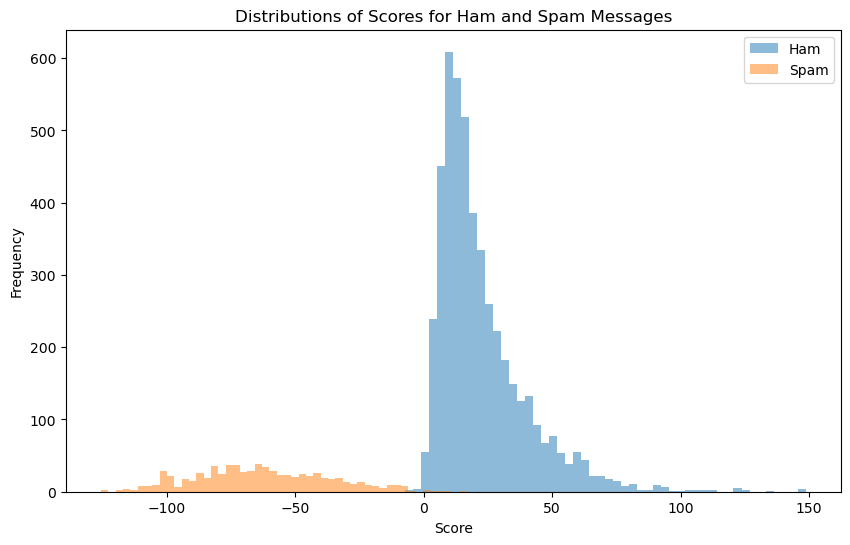

In [220]:
spam_data['tokens'] = spam_data['Message'].apply(lambda x: x.split())
spam_data['token_count'] = spam_data['tokens'].apply(len)
filtered_data = spam_data[spam_data['token_count'] < 75]
filtered_data['score'] = filtered_data.apply(lambda row: score_message(
    row['Message'], freq_ham, freq_spam), axis=1)

ham_scores = filtered_data[filtered_data['Category'] == 'ham']['score']
spam_scores = filtered_data[filtered_data['Category'] == 'spam']['score']

plt.figure(figsize=(10, 6))
plt.hist(ham_scores, bins=50, alpha=0.5, label='Ham')
plt.hist(spam_scores, bins=50, alpha=0.5, label='Spam')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distributions of Scores for Ham and Spam Messages')
plt.savefig('foo.png', bbox_inches='tight')

In [224]:
filtered_data['predicted'] = filtered_data['score'].apply(
    lambda x: 'ham' if x > 1 else 'spam')

conf_matrix = confusion_matrix(
    filtered_data['Category'], filtered_data['predicted'], labels=['ham', 'spam'])
tn, fp, fn, tp = conf_matrix.ravel()

# Calculating accuracy, sensitivity (recall or true positive rate), and specificity (true negative rate)
accuracy = (tp + tn) / (tp + tn + fp + fn)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print(conf_matrix)

[[4786   23]
 [   6  741]]


/var/folders/c1/5zzf4b396wdgc4t2xxg1dqw00000gn/T/ipykernel_4553/3129518842.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['predicted'] = filtered_data['score'].apply(


In [223]:
print(accuracy, sensitivity, specificity)

0.9947804175665946 0.9919678714859438 0.9952173008941568


In [227]:
def calculate_log_odds(message, freq_dist):
    message_tokens = message.split()
    log_odds = 0
    alpha = 2

    for token in message_tokens:
        token_probability = (
            freq_dist[token] + alpha) / (sum(freq_dist.values()) + alpha)
        log_odds += log(token_probability)

    return log_odds


spam_data['tokens'] = spam_data['Message'].apply(lambda x: x.split())
spam_data['token_count'] = spam_data['tokens'].apply(len)
filtered_data = spam_data[spam_data['token_count'] < 75]
filtered_data['score'] = filtered_data.apply(lambda row: score_message(
    row['Message'], freq_ham, freq_spam), axis=1)

ham_scores = filtered_data[filtered_data['Category'] == 'ham']['score']
spam_scores = filtered_data[filtered_data['Category'] == 'spam']['score']

filtered_data['predicted'] = filtered_data['score'].apply(
    lambda x: 'ham' if x > 1 else 'spam')

conf_matrix = confusion_matrix(
    filtered_data['Category'], filtered_data['predicted'], labels=['ham', 'spam'])
tn, fp, fn, tp = conf_matrix.ravel()

# Calculating accuracy, sensitivity (recall or true positive rate), and specificity (true negative rate)
accuracy = (tp + tn) / (tp + tn + fp + fn)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print(conf_matrix, accuracy, sensitivity, specificity)

[[3657 1152]
 [   4  743]] 0.7919366450683946 0.9946452476572959 0.7604491578290705


/var/folders/c1/5zzf4b396wdgc4t2xxg1dqw00000gn/T/ipykernel_4553/2243022235.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['score'] = filtered_data.apply(lambda row: score_message(
/var/folders/c1/5zzf4b396wdgc4t2xxg1dqw00000gn/T/ipykernel_4553/2243022235.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['predicted'] = filtered_data['score'].apply(
